In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score , roc_auc_score
from scipy.stats import expon, reciprocal
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt
from sklearn.feature_selection import SelectFromModel


In [2]:
data=pd.read_csv("data/dementia_dataset.csv")

#### Investigating the Data

In [3]:
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [6]:
data.describe().applymap('{:,.2f}'.format)

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.00,373.00,373.00,373.00,354.00,371.00,373.00,373.00,373.00,373.00
mean,1.88,595.10,77.01,14.60,2.46,27.34,0.29,"1,488.13",0.73,1.20
std,0.92,635.49,7.64,2.88,1.13,3.68,0.37,176.14,0.04,0.14
min,1.00,0.00,60.00,6.00,1.00,4.00,0.00,"1,106.00",0.64,0.88
25%,1.00,0.00,71.00,12.00,2.00,27.00,0.00,"1,357.00",0.70,1.10
50%,2.00,552.00,77.00,15.00,2.00,29.00,0.00,"1,470.00",0.73,1.19
75%,2.00,873.00,82.00,16.00,3.00,30.00,0.50,"1,597.00",0.76,1.29
max,5.00,"2,639.00",98.00,23.00,5.00,30.00,2.00,"2,004.00",0.84,1.59


In [7]:
data.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [4]:
# Create Copy of the data set to work with
df = data.copy()
# Fill in Missing values 
median_ses = df["SES"].median() 
median_mmse = df["MMSE"].median() 
df["SES"].fillna(median_ses, inplace=True)
df["MMSE"].fillna(median_ses, inplace=True)
# Replace 'Group' categories with numbers
df=df.replace('Nondemented', 0).replace('Demented', 1).replace('Converted',2)


In [5]:
df_cat=df.drop(['Subject ID', 'MRI ID', 'Hand'], axis=1) # dropped 'Hand' as all values are the same
df_cat=pd.get_dummies(df_cat).rename({'M/F_F':'Female', 'M/F_M':'Male'}, axis='columns')
df_cat

,Group,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Female,Male
0,0,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883,0,1
1,0,2,457,88,14,2.0,30.0,0.0,2004,0.681,0.876,0,1
2,1,1,0,75,12,2.0,23.0,0.5,1678,0.736,1.046,0,1
3,1,2,560,76,12,2.0,28.0,0.5,1738,0.713,1.010,0,1
4,1,3,1895,80,12,2.0,22.0,0.5,1698,0.701,1.034,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,1,2,842,82,16,1.0,28.0,0.5,1693,0.694,1.037,0,1
369,1,3,2297,86,16,1.0,26.0,0.5,1688,0.675,1.040,0,1
370,0,1,0,61,13,2.0,30.0,0.0,1319,0.801,1.331,1,0
371,0,2,763,63,13,2.0,30.0,0.0,1327,0.796,1.323,1,0


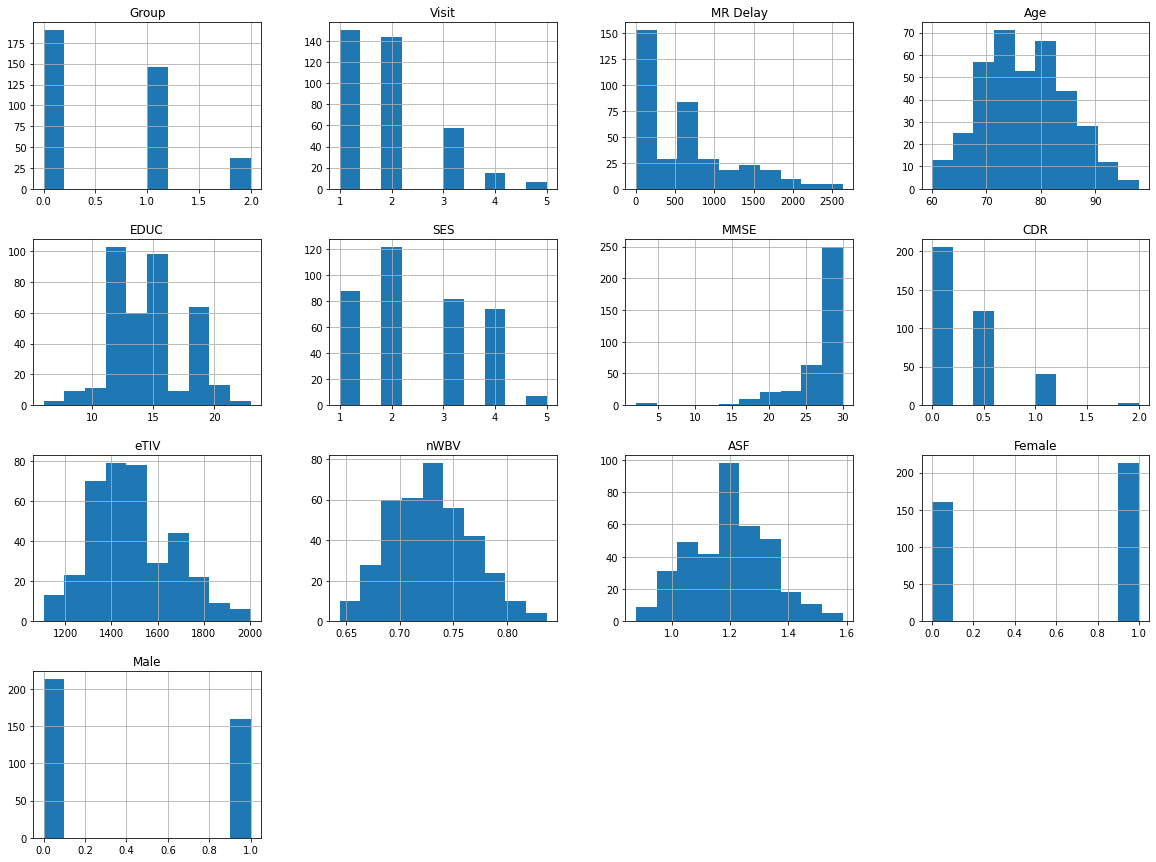

In [47]:
%matplotlib inline
df_cat.hist(figsize=(20,15))
plt.show()

In [48]:
df['M/F'].value_counts()/373

F    0.571046
M    0.428954
Name: M/F, dtype: float64

#### Creating a Test Data Set


In [59]:
# train_set, test_set = train_test_split(df_cat, test_size=0.2, random_state=42)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_cat, df_cat["Group"]):
    strat_train_set = df_cat.loc[train_index]
    strat_test_set = df_cat.loc[test_index]

In [60]:
strat_train_set["Group"].value_counts() / len(strat_train_set)

0    0.510067
1    0.392617
2    0.097315
Name: Group, dtype: float64

In [61]:
df_cat["Group"].value_counts() / len(data)


0    0.509383
1    0.391421
2    0.099196
Name: Group, dtype: float64

#### Data Exploration & Visualisation

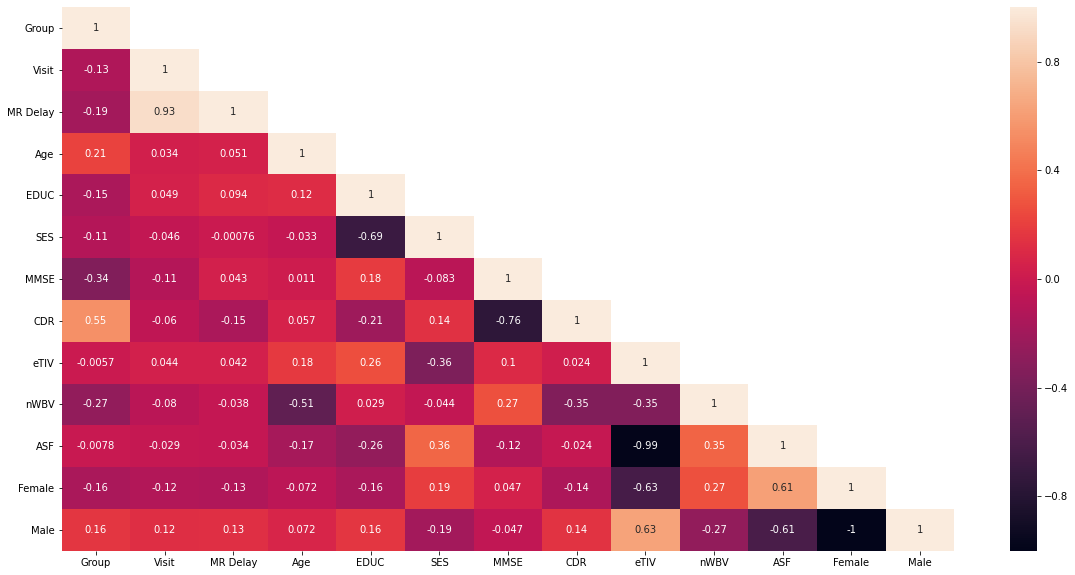

In [62]:
plt.figure(figsize = (20,10))
corr=strat_test_set.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
mask[np.diag_indices_from(mask)] = False
sns.heatmap(corr,annot=True, mask=mask)
plt.show()

Most of the attributes show a distinct lack of colinearity

Those that do show correlations are:
- MR delay with Visit: This makes sense as the higher the visit number the longer the number of days since the beginning of the process
- Social Economic Status against Years in Education 
- Group with CDR: again this makes sense - the higher the CDR then the worse the dementia 
- CDR with MMSE: somewhat strong negative correlation between CDR and MMSE
- nWBV with Age: mild positive correlation
- ASF with eTIV: very strong negative correlation 
- Both ASF and eTIV showed mild postive correlation with both male and females 


### Feature Scaling: Standardisation 


SVMs are sensitive to scales so it's necessary to perform some feature scaling 

to determine what type of scaling we do, we shall first check for the presence of outliers 

In [54]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)   
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [63]:
find_outliers_IQR(strat_train_set)

,Group,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Female,Male
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,NaN,5.0,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,NaN,NaN,NaN,NaN,NaN,NaN,15.0,2.0,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

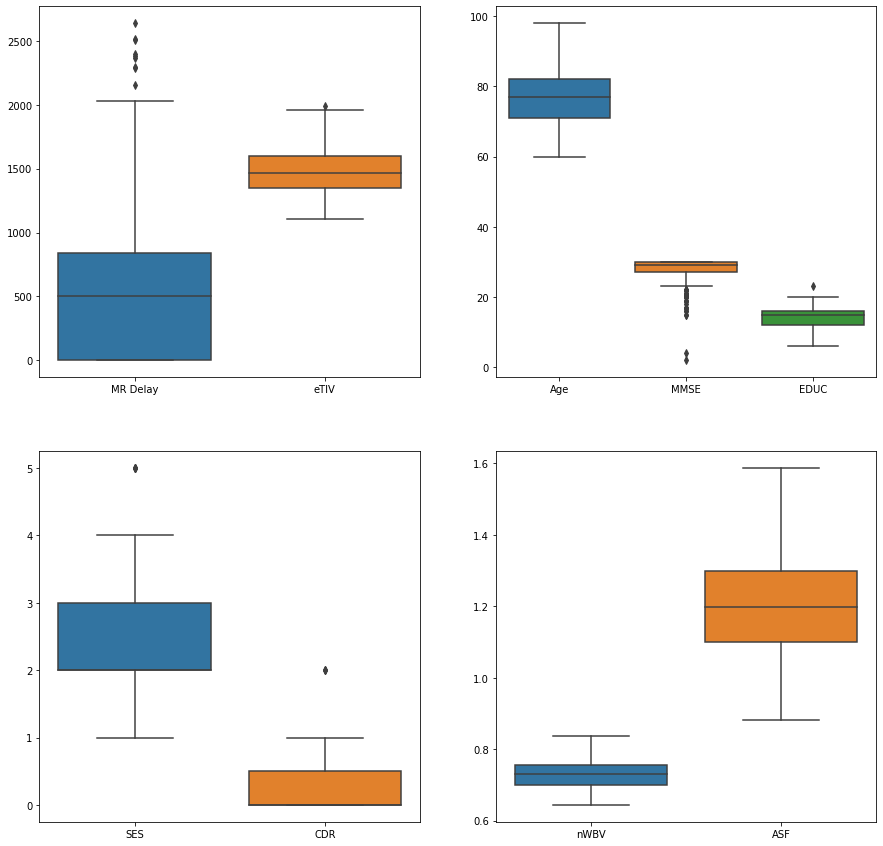

In [64]:
f, ax = plt.subplots(2,2, figsize=(15,15))

sns.boxplot(data=strat_train_set[['MR Delay', 'eTIV']], ax=ax[0,0] )
sns.boxplot(data=strat_train_set[['Age', 'MMSE', 'EDUC']], ax=ax[0,1])
sns.boxplot(data=strat_train_set[['SES', 'CDR']], ax=ax[1,0])
sns.boxplot(data=strat_train_set[['nWBV', 'ASF']], ax=ax[1,1])


It is clear that the data set includes outliers that will affect  the scaling if we use min-max scaling. therefore standardisation is used.

### Preproccessing 

In [2]:
def preprocessing(data):
    scaler=StandardScaler()
    
    data_scaled=data.copy()
    data_scaled.loc[:, ~data_scaled.columns.isin(['Group', 'Visit', 'Male', 'Female'])] = StandardScaler().fit_transform(data_scaled.loc[:, ~data_scaled.columns.isin(['Group', 'Visit', 'Male', 'Female'])])
    
    X=data_scaled.drop("Group", axis=1)
    y=data_scaled['Group'].copy()
    return X, y

In [66]:
# separate out data sets:
X_train, y_train = preprocessing(strat_train_set)

X_test, y_test = preprocessing(strat_test_set)

----------------

# Randomised Search

In [67]:
param_distribs = {
        'kernel': ['linear', 'poly', 'sigmoid'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0), 
        'degree': [0, 1, 2, 3, 4, 5, 6], 
        'probability': [True]
    }

svm_reg = SVC()
scoring = {"ROC_AUC": make_scorer(roc_auc_score, multi_class='ovo'),"Recall": make_scorer(recall_score, average='weighted'),"Accuracy": make_scorer(accuracy_score), "Precision": make_scorer(precision_score, average='weighted')}
rnd_search_rec = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                    n_iter=50, cv=5, scoring=scoring,
                                    refit="ROC_AUC", verbose=2, random_state=42, 
                                    n_jobs=-1)
%time rnd_search_rec.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


CPU times: user 6.55 s, sys: 59.3 ms, total: 6.61 s
Wall time: 25min 40s


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f221d95ab50>,
                                        'degree': [0, 1, 2, 3, 4, 5, 6],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f221daeeac0>,
                                        'kernel': ['linear', 'poly', 'sigmoid'],
                                        'probability': [True]},
                   random_state=42, refit='ROC_AUC',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'Precision': make_scorer(precision_score, average=weighted),
                            'ROC_AUC': make_scorer(roc_auc_score, multi_class=ovo),
                            'Recall': make_scorer(recall_score, average=weighted)},
                   verbose=2)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


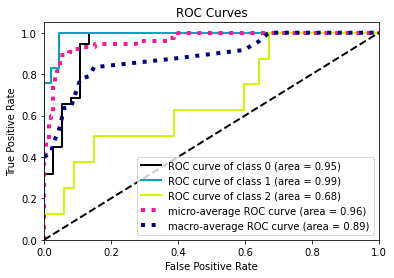

In [71]:
skplt.metrics.plot_roc_curve(y_test, rnd_search_rec.predict_proba(X_test))
plt.show()

In [56]:

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

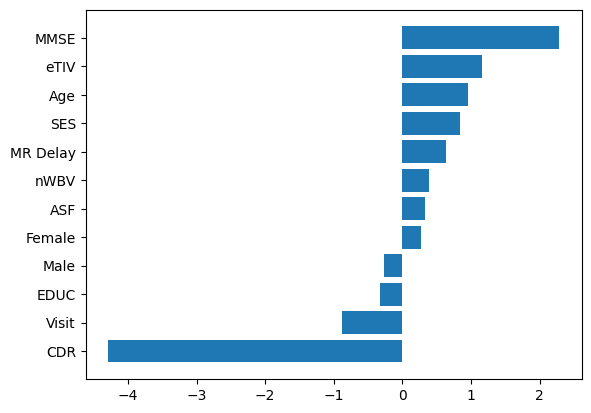

In [66]:
f_importances(rnd_search_rec.best_estimator_.coef_[0], rnd_search_rec.feature_names_in_)

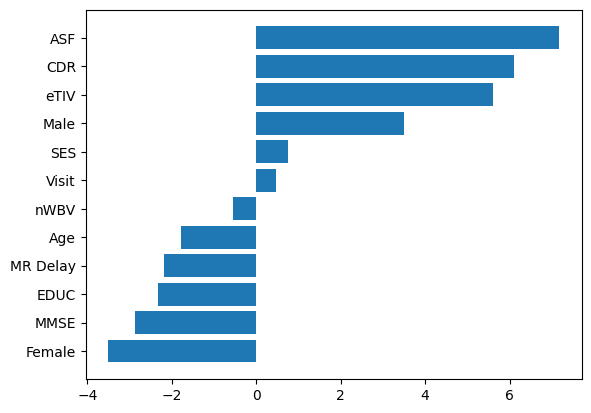

In [68]:
f_importances(rnd_search_rec.best_estimator_.coef_[2], rnd_search_rec.feature_names_in_)

In [57]:
rnd_search_rec.feature_names_in_

array(['Visit', 'MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Female', 'Male'], dtype=object)

In [171]:
rec_finModel=rnd_search_rec.best_params_

In [174]:
rec_finModel_predictions=rnd_search_rec.predict(X_test)

Confusion Matrix



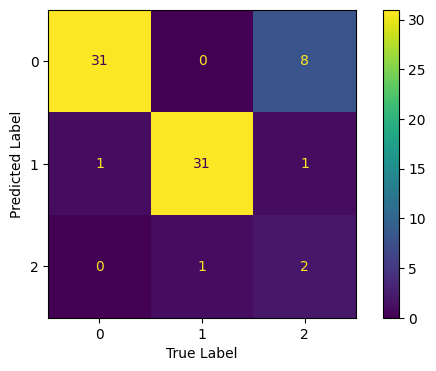



Classification Report:

              precision    recall  f1-score   support

           0      0.795     0.969     0.873        32
           1      0.939     0.969     0.954        32
           2      0.667     0.182     0.286        11

    accuracy                          0.853        75
   macro avg      0.800     0.706     0.704        75
weighted avg      0.838     0.853     0.821        75



In [177]:
 print('Confusion Matrix\n')
# print(metrics.confusion_matrix(y_test, y_pred))

fig, ax = plt.subplots(1,1,figsize=(7,4))

ConfusionMatrixDisplay(confusion_matrix(rec_finModel_predictions,y_test,labels=[0,1,2]),
                       display_labels=[0,1,2]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

print('\n\nClassification Report:\n')
print(metrics.classification_report(y_test, rec_finModel_predictions, digits=3))
    

# Random Forest

In [72]:
param_distribs = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': [2,4,6,8,10,12],
    'bootstrap': [True, False]
    }

rf_clf = RandomForestClassifier()
scoring = {"Recall": make_scorer(recall_score, average='weighted'),"Accuracy": make_scorer(accuracy_score), "Precision": make_scorer(precision_score, average='weighted')}
rnd_forest_RS = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, refit="Recall",
                                   n_iter=50, cv=5, scoring=scoring, verbose=2, random_state=42, 
                                   n_jobs=-1)
%time rnd_forest_RS.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 1.21 s, sys: 10.9 ms, total: 1.22 s
Wall time: 2min 39s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': [2, 4, 6, 8, 10, 12],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, refit='Recall',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'Precision': make_scorer(precision_score, average=weighted),
                            'Recall': make_scorer(recall_score, average=weighted)},
                   verbose=2)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


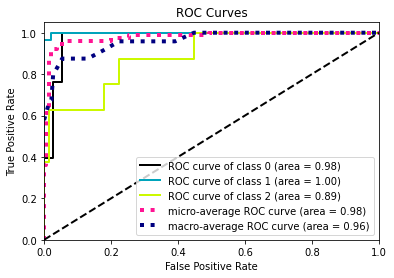

In [73]:
skplt.metrics.plot_roc_curve(y_test, rnd_forest_RS.predict_proba(X_test))
plt.show()

In [76]:
rnd_pred_RS=rnd_forest_RS.predict(X_test)

Confusion Matrix



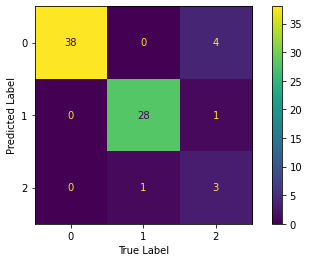



Classification Report:

              precision    recall  f1-score   support

           0      0.905     1.000     0.950        38
           1      0.966     0.966     0.966        29
           2      0.750     0.375     0.500         8

    accuracy                          0.920        75
   macro avg      0.873     0.780     0.805        75
weighted avg      0.912     0.920     0.908        75



In [77]:
 print('Confusion Matrix\n')
# print(metrics.confusion_matrix(y_test, y_pred))

fig, ax = plt.subplots(1,1,figsize=(7,4))

ConfusionMatrixDisplay(confusion_matrix(rnd_pred_RS,y_test,labels=[0,1,2]),
                       display_labels=[0,1,2]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

print('\n\nClassification Report:\n')
print(metrics.classification_report(y_test, rnd_pred_RS, digits=3))
    

# With SMOTE


In [52]:
def preprocessing(data):
    
    
    #Scale Data
    scaler=StandardScaler()
    
    data_scaled=data.copy()
    data_scaled.loc[:, ~data_scaled.columns.isin(['Group', 'Visit', 'Male', 'Female'])] = StandardScaler().fit_transform(data_scaled.loc[:, ~data_scaled.columns.isin(['Group', 'Visit', 'Male', 'Female'])])
    
    X=data_scaled.drop("Group", axis=1)
    y=data_scaled['Group'].copy()
    
       
    # SMOTE
    sm = SMOTE(random_state=42)

    X_sm, y_sm = sm.fit_resample(X, y)
    
    print(f'''Shape of X before SMOTE: {X.shape}
    Shape of X after SMOTE: {X_sm.shape}''')

    print(f'\nBalance of positive and negative classes (%): \n{y_sm.value_counts(normalize=True) * 100}')
    
    pd.concat([pd.DataFrame(y_sm),X_sm], axis=1)

    return  pd.concat([pd.DataFrame(y_sm),X_sm], axis=1)

In [55]:
data_processed=preprocessing(df_cat)
train_set, test_set = train_test_split(data_processed, test_size=0.3, random_state=42)


Shape of X before SMOTE: (373, 12)
    Shape of X after SMOTE: (570, 12)

Balance of positive and negative classes (%): 
0    33.333333
1    33.333333
2    33.333333
Name: Group, dtype: float64


In [57]:
X_train=train_set.drop("Group", axis=1)
y_train=train_set['Group'].copy()

X_test=test_set.drop("Group", axis=1)
y_test=test_set['Group'].copy()

##### Randomised Search - SVM


In [61]:
param_distribs = {
        'kernel': ['linear', 'poly', 'sigmoid'],
        'C': reciprocal(20, 200000),
#         'gamma': expon(scale=1.0), 
        'degree': [0, 1, 2, 3, 4, 5, 6], 
        'probability': [True]
    }

svm_reg = SVC()
scoring = {"ROC_AUC": make_scorer(roc_auc_score, multi_class='ovo'),"Recall": make_scorer(recall_score, average='weighted'),"Accuracy": make_scorer(accuracy_score), "Precision": make_scorer(precision_score, average='weighted')}
smote_rndSearch_svm = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                    n_iter=50, cv=5, scoring=scoring,
                                    refit="ROC_AUC", verbose=2, random_state=42, 
                                    n_jobs=-1)
%time smote_rndSearch_svm.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 561 ms, sys: 57.6 ms, total: 619 ms
Wall time: 27min 43s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f12c48ba040>,
                                        'degree': [0, 1, 2, 3, 4, 5, 6],
                                        'kernel': ['linear', 'poly', 'sigmoid'],
                                        'probability': [True]},
                   random_state=42, refit='ROC_AUC',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'Precision': make_scorer(precision_score, average=weighted),
                            'ROC_AUC': make_scorer(roc_auc_score, multi_class=ovo),
                            'Recall': make_scorer(recall_score, average=weighted)},
                   verbose=2)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


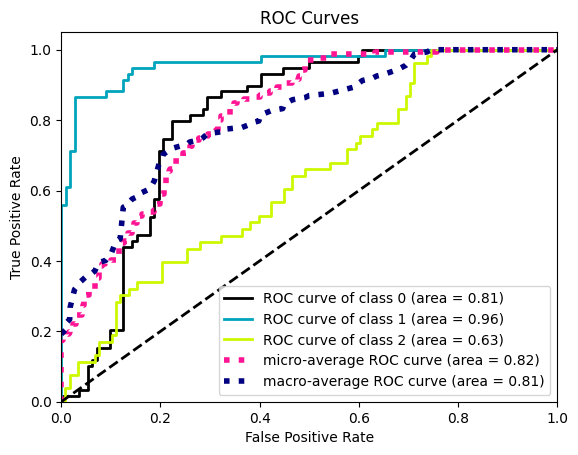

In [62]:
skplt.metrics.plot_roc_curve(y_test, smote_rndSearch_svm.predict_proba(X_test))
plt.show()

Confusion Matrix



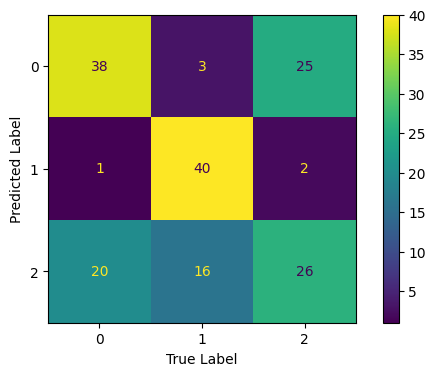



Classification Report:

              precision    recall  f1-score   support

           0      0.576     0.644     0.608        59
           1      0.930     0.678     0.784        59
           2      0.419     0.491     0.452        53

    accuracy                          0.608       171
   macro avg      0.642     0.604     0.615       171
weighted avg      0.650     0.608     0.621       171



In [63]:
rec_finModel_predictions=smote_rndSearch_svm.predict(X_test)
print('Confusion Matrix\n')
# print(metrics.confusion_matrix(y_test, y_pred))

fig, ax = plt.subplots(1,1,figsize=(7,4))

ConfusionMatrixDisplay(confusion_matrix(rec_finModel_predictions,y_test,labels=[0,1,2]),
                       display_labels=[0,1,2]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

print('\n\nClassification Report:\n')
print(metrics.classification_report(y_test, rec_finModel_predictions, digits=3))

##### Randomised Search Random Forest

In [64]:
param_distribs = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': [2,4,6,8,10,12],
    'bootstrap': [True, False]
    }

rf_clf = RandomForestClassifier()
scoring = {"Recall": make_scorer(recall_score, average='weighted'),"Accuracy": make_scorer(accuracy_score), "Precision": make_scorer(precision_score, average='weighted')}
smote_rnd_forest_RS = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, refit="Recall",
                                   n_iter=50, cv=5, scoring=scoring, verbose=2, random_state=42, 
                                   n_jobs=-1)
%time smote_rnd_forest_RS.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 1.98 s, sys: 58.7 ms, total: 2.04 s
Wall time: 3min 4s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': [2, 4, 6, 8, 10, 12],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, refit='Recall',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'Precision': make_scorer(precision_score, average=weighted),
                            'Recall': make_scorer(recall_score, average=weighted)},
                   verbose=2)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


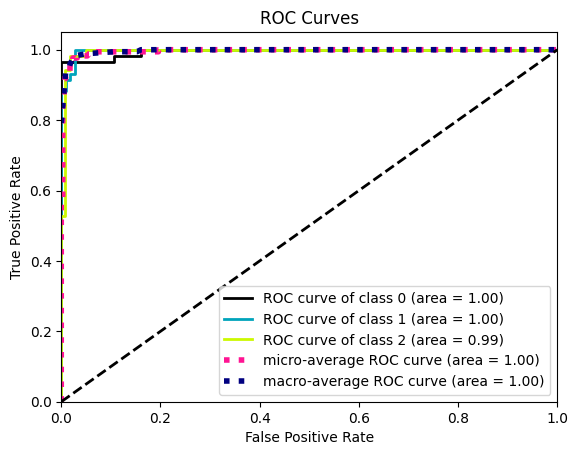

In [65]:
skplt.metrics.plot_roc_curve(y_test, smote_rnd_forest_RS.predict_proba(X_test))
plt.show()

Confusion Matrix



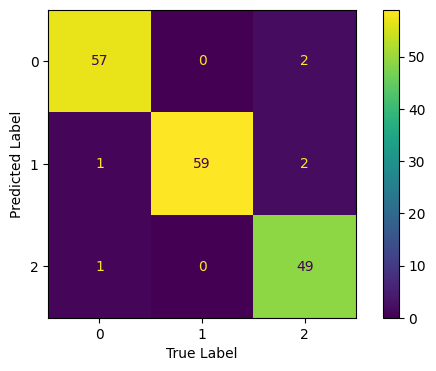



Classification Report:

              precision    recall  f1-score   support

           0      0.966     0.966     0.966        59
           1      0.952     1.000     0.975        59
           2      0.980     0.925     0.951        53

    accuracy                          0.965       171
   macro avg      0.966     0.964     0.964       171
weighted avg      0.965     0.965     0.965       171



In [70]:
rf_finModel_predictions=smote_rnd_forest_RS.predict(X_test)
print('Confusion Matrix\n')
# print(metrics.confusion_matrix(y_test, y_pred))

fig, ax = plt.subplots(1,1,figsize=(7,4))

ConfusionMatrixDisplay(confusion_matrix(rf_finModel_predictions,y_test,labels=[0,1,2]),
                       display_labels=[0,1,2]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

print('\n\nClassification Report:\n')
print(metrics.classification_report(y_test, rf_finModel_predictions, digits=3))
    